In [ ]:
!apt-get install subversion > /dev/null
!svn export https://github.com/TiaAF1/Aplikasi-CNN-Klasifikasi-3-Varietas-Beras/ > /dev/null

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [6]:
!ls Aplikasi-CNN-Klasifikasi-3-Varietas-Beras/trunk/data/image
!ls Aplikasi-CNN-Klasifikasi-3-Varietas-Beras/trunk/data/image/train
!ls Aplikasi-CNN-Klasifikasi-3-Varietas-Beras/trunk/data/image/train/Basmathi
!ls Aplikasi-CNN-Klasifikasi-3-Varietas-Beras/trunk/data/image/train/IR64
!ls Aplikasi-CNN-Klasifikasi-3-Varietas-Beras/trunk/data/image/train/Ketan

test  train
Basmathi  IR64	Ketan
B10.jpg  B19.jpg  B27.jpg  B35.jpg  B43.jpg  B51.jpg  B5.jpg   B68.jpg	B7.jpg
B11.jpg  B1.jpg   B28.jpg  B36.jpg  B44.jpg  B52.jpg  B60.jpg  B69.jpg	B8.jpg
B12.jpg  B20.jpg  B29.jpg  B37.jpg  B45.jpg  B53.jpg  B61.jpg  B6.jpg	B9.jpg
B13.jpg  B21.jpg  B2.jpg   B38.jpg  B46.jpg  B54.jpg  B62.jpg  B70.jpg
B14.jpg  B22.jpg  B30.jpg  B39.jpg  B47.jpg  B55.jpg  B63.jpg  B71.jpg
B15.jpg  B23.jpg  B31.jpg  B3.jpg   B48.jpg  B56.jpg  B64.jpg  B72.jpg
B16.jpg  B24.jpg  B32.jpg  B40.jpg  B49.jpg  B57.jpg  B65.jpg  B73.jpg
B17.jpg  B25.jpg  B33.jpg  B41.jpg  B4.jpg   B58.jpg  B66.jpg  B74.jpg
B18.jpg  B26.jpg  B34.jpg  B42.jpg  B50.jpg  B59.jpg  B67.jpg  B75.jpg
I10.jpg  I19.jpg  I27.jpg  I35.jpg  I43.jpg  I51.jpg  I5.jpg   I68.jpg	I7.jpg
I11.jpg  I1.jpg   I28.jpg  I36.jpg  I44.jpg  I52.jpg  I60.jpg  I69.jpg	I8.jpg
I12.jpg  I20.jpg  I29.jpg  I37.jpg  I45.jpg  I53.jpg  I61.jpg  I6.jpg	I9.jpg
I13.jpg  I21.jpg  I2.jpg   I38.jpg  I46.jpg  I54.jpg  I62.jpg  I70.jpg
I14.

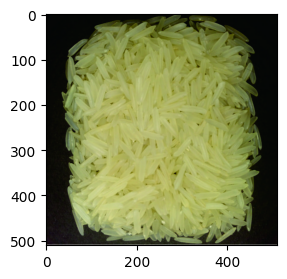

In [9]:
image = imread("Aplikasi-CNN-Klasifikasi-3-Varietas-Beras/trunk/data/image/train/Basmathi/B16.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [10]:
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('Aplikasi-CNN-Klasifikasi-3-Varietas-Beras/trunk/data/image/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

X_test = []
y_test = []
labels = ['Basmathi', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("Aplikasi-CNN-Klasifikasi-3-Varietas-Beras/trunk/data/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 180 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validation (validasi) adalah: (45, 224, 224, 3) (45, 3)
Bentuk array dari dataset test (pengujian) adalah: (45, 224, 224, 3) (45,)


In [11]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Basmathi': 0, 'IR64': 1, 'Ketan': 2}


In [12]:
!cat labels.txt

Basmathi
IR64
Ketan

In [13]:
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [ ]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          294944    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 3,523,907
Trainable params: 295,043
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
history = model.fit_generator(train_generator, 
                    epochs=100, 
                    validation_data=val_generator)

<ipython-input-17-67338b47e58e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/100
2/2 [==============================] - 10s 3s/step - loss: 1.6898 - acc: 0.3333 - val_loss: 1.9525 - val_acc: 0.3333
Epoch 2/100
2/2 [==============================] - 7s 3s/step - loss: 1.4476 - acc: 0.4167 - val_loss: 0.6845 - val_acc: 0.5778
Epoch 3/100
2/2 [==============================] - 8s 5s/step - loss: 0.6454 - acc: 0.6944 - val_loss: 0.8601 - val_acc: 0.6667
Epoch 4/100
2/2 [==============================] - 7s 3s/step - loss: 0.5990 - acc: 0.7278 - val_loss: 0.2608 - val_acc: 0.9556
Epoch 5/100
2/2 [==============================] - 7s 5s/step - loss: 0.1811 - acc: 0.9444 - val_loss: 0.2300 - val_acc: 0.9556
Epoch 6/100
2/2 [==============================] - 8s 6s/step - loss: 0.1523 - acc: 0.9389 - val_loss: 0.0714 - val_acc: 0.9778
Epoch 7/100
2/2 [==============================] - 8s 6s/step - loss: 0.0363 - acc: 1.0000 - val_loss: 0.0803 - val_acc: 0.9778
Epoch 8/100
2/2 [==============================] - 7s 5s/step - loss: 0.0469 - acc: 0.9889 - val_loss: 

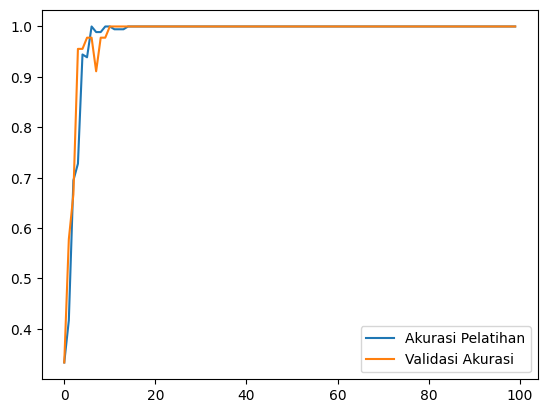

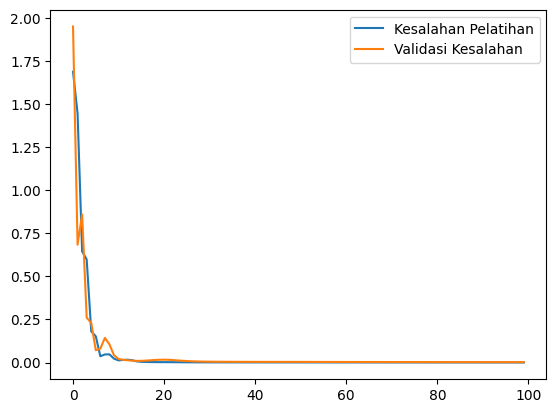

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [ ]:
print(train_generator)

In [ ]:
print(model.metrics_names)
print(model.evaluate(train_generator))
print(model.evaluate(val_generator))
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
2/2 [==============================] - 6s 1s/step - loss: 2.0256e-04 - acc: 1.0000
[0.00020255894924048334, 1.0]
1/1 [==============================] - 2s 2s/step - loss: 0.0021 - acc: 1.0000
[0.002110194880515337, 1.0]
2/2 [==============================] - 1s 446ms/step - loss: 0.0042 - acc: 1.0000
[0.004249445628374815, 1.0]


In [ ]:
y_true = np.argmax(y_test2,axis=1)

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

2/2 [==============================] - 2s 384ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


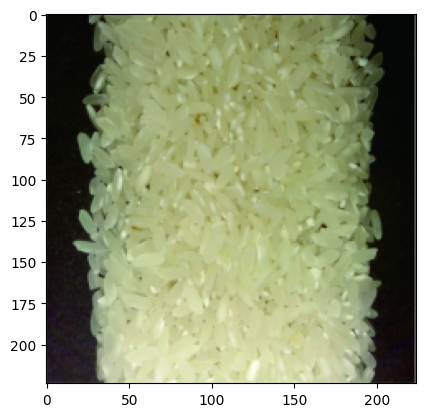

Label yang benar adalah: 1 : IR64
1/1 [==============================] - 0s 51ms/step
Nilai yang diprediksi adalah: [6.1067309e-05 9.9968266e-01 2.5631193e-04]
Label yang diprediksi adalah: 1 : IR64
Prediksi benar


In [ ]:
n = 27

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


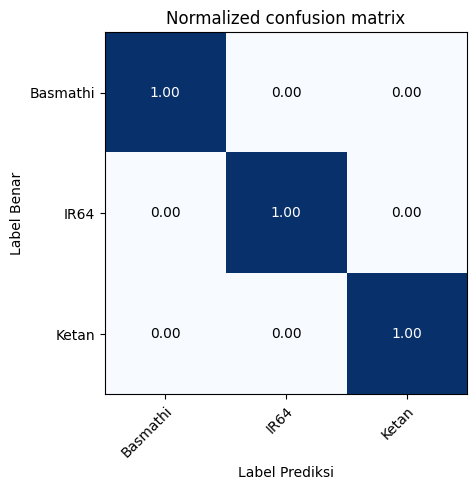

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_3_Jenis_Beras.tflite', 'wb') as f:
  f.write(tflite_model)